In [27]:
%%bash
if [ `pwd` != "/home/dsxuser/work"  ]; then 
    echo "Not running in Watson Studio, installing additional packages";
    !pip install --upgrade pip
    !pip install wrapt --upgrade --ignore-installed
    !pip install --upgrade msgpack numpy
    echo "finished, please restart your kernel"
fi

In [ ]:
!pip install --upgrade keras-applications keras-preprocessing setuptools tensorflow keras

In [1]:
import tensorflow
if not tensorflow.__version__ == '1.14.0':
    print(tensorflow.__version__)
    raise ValueError('please upgrade to TensorFlow 1.14.0, or restart your Kernel (Kernel->Restart & Clear Output)')

import keras
if not keras.__version__ == '2.2.5':
    print(keras.__version__)
    raise ValueError('please upgrade to Keras 2.2.5, or restart your Kernel (Kernel->Restart & Clear Output)')

Using TensorFlow backend.


In [2]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from  sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from queue import Queue
%matplotlib inline

In [3]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle

rm: cannot remove ‘watsoniotp.*’: No such file or directory
--2019-09-06 14:22:18--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

100%[======================================>] 194,639     --.-K/s   in 0.01s   

2019-09-06 14:22:18 (14.2 MB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2019-09-06 14:22:19--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubuserconte

In [4]:
data_healthy = pickle.load(open('watsoniotp.healthy.phase_aligned.pickle', 'rb'), encoding="latin1")
data_broken = pickle.load(open('watsoniotp.broken.phase_aligned.pickle', 'rb'), encoding="latin1")

In [5]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

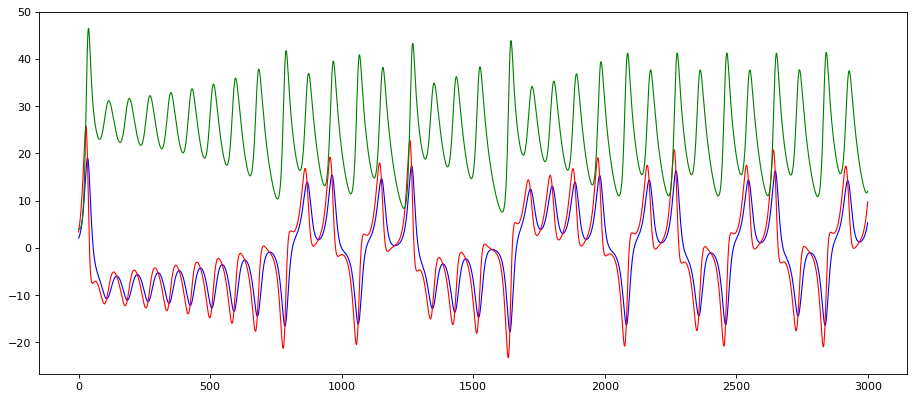

In [6]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1)

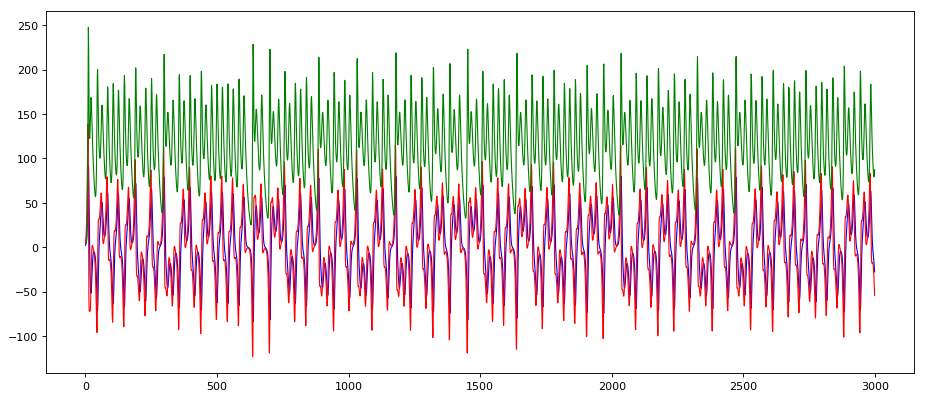

In [7]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1)

In [8]:
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

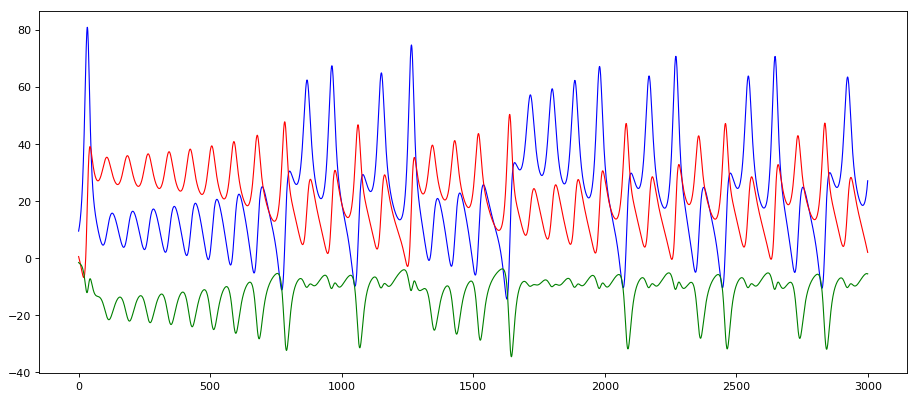

In [9]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)


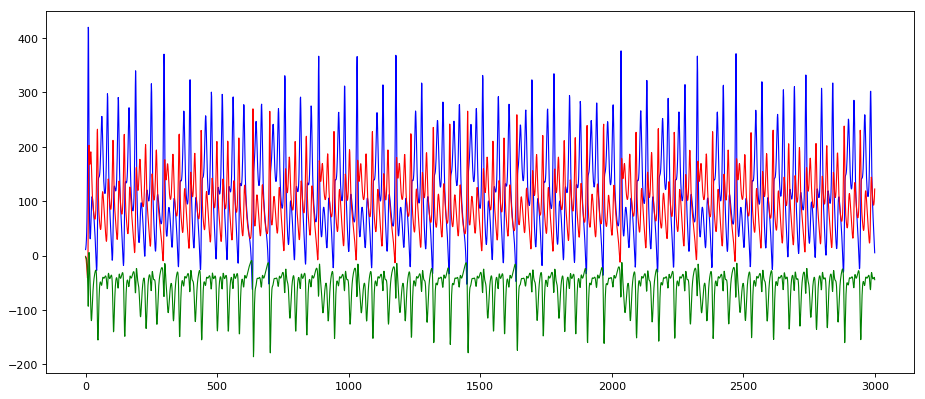

In [10]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)


In [11]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [12]:
data_healthy_scaled = scaleData(data_healthy)
data_broken_scaled = scaleData(data_broken)

In [13]:
timesteps = 10
dim = 3
samples = 3000
data_healthy_scaled_reshaped = data_healthy_scaled
data_healthy_scaled_reshaped.shape = (int(samples/timesteps),timesteps,dim)

In [14]:
data_healthy_scaled_reshaped.shape

(300, 10, 3)

In [15]:
losses = []

def handleLoss(loss):
        global losses
        losses+=[loss]
        print(loss)

In [16]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        handleLoss(logs.get('loss'))

In [17]:
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

def train(data):
    data.shape = (300, 10, 3)
    model.fit(data, data, epochs=50, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[LossHistory()])
    data.shape = (3000, 3)

def score(data):
    data.shape = (300, 10, 3)
    yhat =  model.predict(data)
    yhat.shape = (3000, 3)
    return yhat

W0906 14:22:27.567401 140289440601920 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 14:22:27.589326 140289440601920 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 14:22:27.592632 140289440601920 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 14:22:40.235966 140289440601920 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [18]:
for i in range(3):
    
    print("----------------")
    train(data_healthy_scaled)
    yhat_healthy = score(data_healthy_scaled)
    yhat_broken = score(data_broken_scaled)
    data_healthy_scaled.shape = (3000, 3)
    data_broken_scaled.shape = (3000, 3)


print ("----------------broken")
train(data_broken_scaled)
yhat_healthy = score(data_healthy_scaled)
yhat_broken = score(data_broken_scaled)
data_healthy_scaled.shape = (3000, 3)
data_broken_scaled.shape = (3000, 3)

----------------


W0906 14:22:40.750794 140289440601920 deprecation.py:323] From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0906 14:22:49.582525 140289440601920 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0906 14:22:50.124626 140289440601920 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 300 samples, validate on 300 samples
Epoch 1/50
288/300 [===========================>..] - ETA: 0s - loss: 0.44450.44562382
0.5183383
300/300 [==============================] - 11s 37ms/step - loss: 0.4475 - val_loss: 0.4168
Epoch 2/50
288/300 [===========================>..] - ETA: 0s - loss: 0.39240.38180757
0.44113794
300/300 [==============================] - 1s 3ms/step - loss: 0.3944 - val_loss: 0.3323
Epoch 3/50
288/300 [===========================>..] - ETA: 0s - loss: 0.29480.2794699
0.3111718
300/300 [==============================] - 1s 3ms/step - loss: 0.2954 - val_loss: 0.2891
Epoch 4/50
288/300 [===========================>..] - ETA: 0s - loss: 0.28670.28572825
0.28978947
300/300 [==============================] - 1s 3ms/step - loss: 0.2868 - val_loss: 0.2609
Epoch 5/50
288/300 [===========================>..] - ETA: 0s - loss: 0.25280.25249404
0.28542173
300/300 [==============================] - 1s 3ms/step - loss: 0.2541 - val_loss: 0.2438
Epoch 6/50
288/300 [

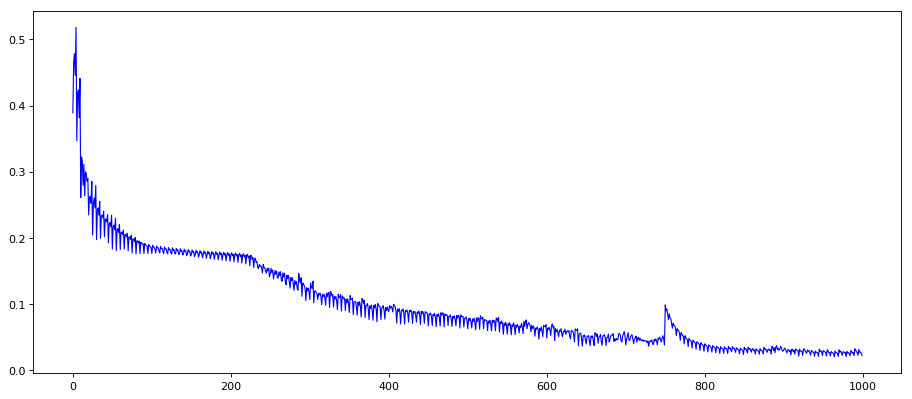

In [19]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,len(losses)), losses, '-', color='blue', animated = True, linewidth=1)